In [1]:
"""
Evaluation scripts for the PyBirales paper.
Notebook reproduces the figures used in the paper.

"""
import os
import re
import pandas as pd
import numpy as np
from analysis import sns

import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 10)



In [2]:
OUT_DIR = "/home/denis/.birales/visualisation/analysis/phd_results"
SAVE_FIGURES = False
LOG_DIR = '/home/denis/Documents/PhD/birales/2018'

In [3]:
# 1. Average timings per module

# LOG_DIR = '/var/log/birales'
log_files = []
for subdir, dirs, files in os.walk(LOG_DIR):
    for log_file in files:
        log_files.append(os.path.join(subdir, log_file))


def profile_modules(log_files, modules, skip=['Detector']):
    profiling = []    
    processed_logfiles = 0
    for log_file_path in log_files:
        lines = []
        profiling_modules = []
        with open(log_file_path, 'r') as f:
           log_lines = f.readlines()

        # Iterate each line
        level = 'INFO'
        pattern = 'in [-+]?([0-9]*\.[0-9]+|[0-9]+) s'

        for i, line in enumerate(log_lines):
            split_line = line.split()
            
            match = re.search(pattern, line)
            time_taken = 0
            found = 0
            if match:
                module_name = split_line[5]
                time_taken = float(match.group().split()[1])
                # Skip log_files which contain the detector
                if module_name in skip:
                    break
                    
            match_detections = re.search('Found [-+]?([0-9]*\.[0-9]+|[0-9]+) new candidates', line)
            if match_detections:
                module_name = split_line[5]
                found = int(match_detections.group().split()[1])
            
            if match or match_detections:
                if module_name in modules:
                    profiling_modules.append({'Module': module_name, 'Processing Time': time_taken, 'Candidates Found': found})  
                
        else:
            profiling += profiling_modules
            
        processed_logfiles += 1
    print 'Processed %s / %s log files' % (processed_logfiles, len(log_files))
    
    return  pd.DataFrame(profiling)

def out_file(filename):
    return os.path.join(OUT_DIR,'{}.pdf'.format(filename))


Processed 190 / 190 log files


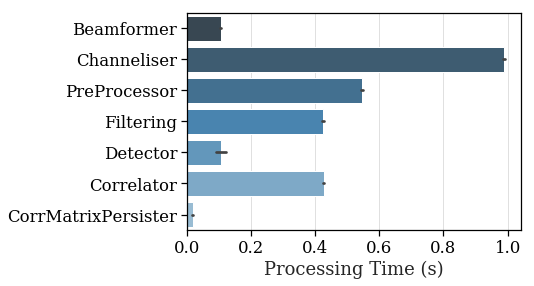

In [4]:
# 1.1 Average timings per module - PyBirales Modules
modules = ['Filtering',  'Correlator','PreProcessor','Channeliser','Beamformer',
           'Detector', 'Receiver', 'RawDataReader', 'Dummy-8','RawDataReader',
           'RawPersister','CorrMatrixPersister','FilteredFitsPersister','RawFitsPersister']

skip=['RawPersister', 'FilteredFitsPersister','RawFitsPersister']
p_df = profile_modules(log_files, modules, skip=skip)
ax = sns.barplot(y="Module", x="Processing Time", data=p_df, palette="Blues_d")
ax.set(ylabel='', xlabel='Processing Time (s)')

p_df.groupby('Module').mean()

if SAVE_FIGURES:
    plt.savefig(out_file('eval_modules'), bbox_inches='tight')

Processed 152 / 190 log files (Skipped 38)


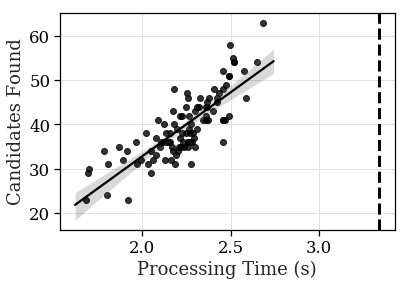

In [5]:
# 2. Total time for a detection
# 1.1 Average timings per module - PyBirales Modules


# 1. Average timings per module

def profile_detector(log_files, skip=[]):
    profiling = []    
    processed_logfiles = 0
#     log_files = ['/home/denis/Documents/PhD/birales/2018/2018_12_08/D1.log']
    for log_file_path in log_files:
        lines = []
        profiling_modules = []
        with open(log_file_path, 'r') as f:
            log_lines = f.readlines()

        # Iterate each line        
        found = 0
        time_taken = 0
        for i, line in enumerate(log_lines):
            split_line = line.split()
                
            match_detections = re.search('Found [-+]?([0-9]*\.[0-9]+|[0-9]+) new candidates', line)
            if match_detections:
                found = int(match_detections.group().split()[1])
                continue
                        
            match = re.search('in [-+]?([0-9]*\.[0-9]+|[0-9]+) s', line)
            if match:
                module_name = split_line[5]
                
                if module_name == 'Detector':
                    time_taken = float(match.group().split()[1])

                    if time_taken > 0.:
                        profiling_modules.append({'Module': 'Detector', 'Processing Time': time_taken, 'Candidates Found': found})  
                    
                    if time_taken > 2 and found == 0:
                        print log_file_path, i
                    time_taken = 0
                    found=0
                elif module_name in skip:
                    break        
        else:
            profiling += profiling_modules
            processed_logfiles += 1
    
        
        
    print 'Processed %s / %s log files (Skipped %s)' % (processed_logfiles, len(log_files), len(log_files)-processed_logfiles)
    
    return  pd.DataFrame(profiling)

skip=['RawPersister', 'FilteredFitsPersister','RawFitsPersister']
pd_df = profile_detector(log_files, skip)
pd_df = pd_df[pd_df['Candidates Found']  > 10]
ax = sns.regplot(x=pd_df['Processing Time'], y=pd_df['Candidates Found'], color='black')
ax.set(xlabel='Processing Time (s)', ylabel='Candidates Found')
ax.axvline(x=3.34, color='black', ls='--', lw=3)

if SAVE_FIGURES:
    plt.savefig(out_file('detector_scaling'), bbox_inches='tight')

Processed 1 / 1 log files
Processed 1 / 1 log files
Processed 1 / 1 log files
     Candidates Found       Module   time  scaling       p_time
0                   0   Beamformer  0.096       32  3495.208333
496                 0  Channeliser  0.783       32   428.531290
497                 0   Beamformer  0.092       32  3647.173913
498                 0  Channeliser  0.777       32   431.840412
499                 0   Beamformer  0.092       32  3647.173913


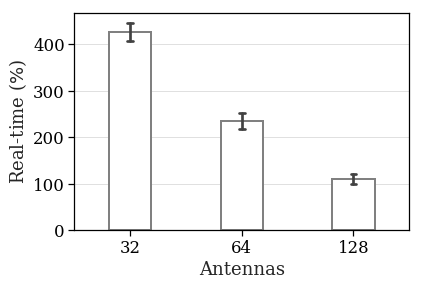

In [20]:
# 3. Scaling to 64 antennas
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

scaling_dir = '/var/log/birales/2019_02_15'
log_files_scaling = [
#     (os.path.join(scaling_dir, 'DUMMY16.log'), 16),
    (os.path.join(scaling_dir, 'DUMMY32.log'), 32),
    (os.path.join(scaling_dir, 'DUMMY64.log'), 64),
    (os.path.join(scaling_dir, 'DUMMY128.log'), 128)
]

skip=['RawPersister', 'FilteredFitsPersister','RawFitsPersister']
REAL_TIME = 3.3554
frames = []
for i in range(0, len(log_files_scaling)):
    log_file = log_files_scaling[i]
    df = profile_modules([log_file[0]], modules, skip=skip)  
    df = df.rename(columns={'Processing Time': 'time'})
    df['scaling'] = log_file[1]
    df['p_time'] = REAL_TIME / df['time']*100
    frames.append(df)
    
ps_df = pd.concat(frames)
ps_df = ps_df.sort_values(['scaling'])


print ps_df.head()
c_data = ps_df[ps_df['Module'] == 'Channeliser']
b_data = ps_df[ps_df['Module'] == 'Beamformer']
errors_kw = dict(capsize=9, capthick=3, elinewidth=3, zorder=4, ecolor='#666666')
ax = sns.barplot(x="scaling", y='p_time', data=c_data, ci='sd', color='white', edgecolor="gray", linewidth=2, capsize=0.05)
ax.set(xlabel='Antennas', ylabel=r'Real-time ($\%$)' )
change_width(ax, .38)
SAVE_FIGURES = True
if SAVE_FIGURES:
    plt.savefig(out_file('birales_scaling_channeliser'), bbox_inches='tight')


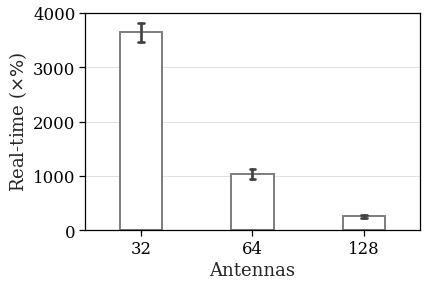

In [23]:

ax1 = sns.barplot(x="scaling", y='p_time', data=b_data[b_data['scaling']> 16], ci='sd', color='white', edgecolor="gray", linewidth=2, capsize =0.05)
ax1.set(xlabel='Antennas', ylabel=r'Real-time ($\times \%$)')
change_width(ax1, .38)

SAVE_FIGURES = True
if SAVE_FIGURES:
    plt.savefig(out_file('birales_scaling_beamformer'), bbox_inches='tight')

IOError: [Errno 2] No such file or directory: '/home/denis/.birales/visualisation/fits/norad_25160_calibrated/Observation_2019-03-12T1334_raw_5.fits'

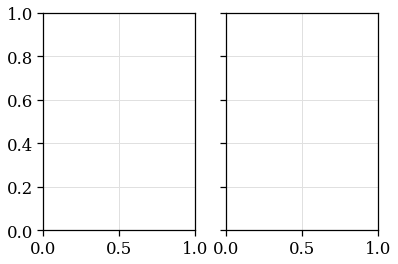

In [8]:
from analysis import C_MAP
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0, dark=0.9, as_cmap=True)

def get_image_data(filename, time_range, channel_range):
   hdu_list = fits.open(filename)
   image_data = hdu_list[0].data.byteswap().newbyteorder()[0] # get 1 beam
   print('Data shape: {} channels and {} samples'.format(image_data.shape[0], image_data.shape[1])) 
    
   return image_data[channel_range[0]:channel_range[1], time_range[0]:time_range[1]]

def waterfall(power, axes):
    ax = sns.heatmap(power, cbar_kws={'label': 'Power (dB)'}, 
                  square=True, xticklabels=50, yticklabels=50,cmap=cmap, ax = axes)
    ax.invert_yaxis()
    ax.set(xlabel='Time sample', ylabel='Channel')   
    
    return ax

FITS_ROOT = '/home/denis/.birales/visualisation/fits/'
f, axes = plt.subplots(1, 2, sharey = True)

RAW_FITS = os.path.join(FITS_ROOT, "norad_25160_calibrated/Observation_2019-03-12T1334_raw_5.fits")
power_c = get_image_data(RAW_FITS, time_range=[450, 750], channel_range=[4050, 4350])

RAW_FITS = os.path.join(FITS_ROOT, "norad_25160_uncalibrated/Observation_2019-03-12T1341_raw_5.fits")
power_nc = get_image_data(RAW_FITS, time_range=[450, 750], channel_range=[4050, 4350])

ax1 =  waterfall(power_c, axes[0])
ax2 =  waterfall(power_nc, axes[1])


# if SAVE_FIGURES:
#     plt.savefig(OUT_DIR+'/before_filtering.pdf')

In [ ]:
ax1 = sns.lineplot(y=np.max(power_c,axis=1), x=np.arange(0, 300))
ax2 = sns.lineplot(y=np.max(power_nc,axis=1), x=np.arange(0, 300))

In [ ]:
ax1 =  waterfall(power_c, None)
SAVE_FIGURES =False
if SAVE_FIGURES:
    plt.savefig(OUT_DIR+'/channeliser_ouput.pdf')

In [ ]:
# 5. Multi-pixel map with beams lit-on (showing trajectory)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
a = np.cos(50.0 * 2.0*np.pi*x) + np.sin(50.0 * 2.0*np.pi*x) *1j
y = a 
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax.plot(yf)
plt.show()

In [ ]:
F = 2
duration = 3.35

N = F*duration

events = []
tosses = 10000
for i in range(0, tosses):
    r = np.random.uniform(0, 1)

    if r >= 0.3:
        events.append(r)
    
print len(events)* 1.0 / tosses 
print N

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

fs = 800

f = 137.3455
t = 2

samples = np.linspace(0, t, int(fs*t), endpoint=False)
signal = np.sin(2 * np.pi * f * samples )

noise = (np.random.random(len(signal))/20)

signal += noise


gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(12, 7), facecolor='w')
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])


ax0.plot(signal)
ax0.set_title("Signal @ "+str("%9.6f"%(f))+" MHz with added white noise")
ax0.set_ylim(-1,1)
ax1.set_xlabel("Samples")

window = np.hanning(len(signal))
spectrum = 20 * np.log10(np.abs(np.real(np.fft.rfft(signal*window))))
asse_x = np.linspace(0,fs/2, len(spectrum))
ax1.plot(asse_x, spectrum)
ax1.set_title("Power Spectrum")
ax1.set_xlabel("MHz")
x_annotation = asse_x[0] + ((asse_x[-1] - asse_x[0]) / 4 * 3)
print x_annotation
RBW = len(spectrum) / (fs/2)
ax1.annotate("RBW: " + str("%3.1f" % RBW) + "KHz", (x_annotation, 15), fontsize=16)
plt.tight_layout()
plt.show()

print len(signal)
